In [1]:
import nltk
nltk.download('abc')
nltk.download('punkt')
from nltk.corpus import abc

[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
from collections import Counter
from itertools import dropwhile

word_list = [word.lower() for word in abc.words() if word.isalnum()]
word_count = Counter(word_list)
word_count = word_count.most_common()
id_to_word = dict()
word_to_id = dict()
for i in range(len(word_count)):
    word_to_id[word_count[i][0]] = i
    id_to_word[i] = word_count[i][0]
id_list = list()
for word in word_list:
    if word in word_to_id:
        id_list.append(word_to_id[word])
number_of_words_in_dataset = len(id_list)
number_of_words_in_vocabulary = len(word_count)

In [3]:
from keras.preprocessing.sequence import skipgrams, make_sampling_table
import numpy as np

couples, labels = skipgrams(id_list, vocabulary_size=number_of_words_in_dataset, window_size=3, sampling_table=make_sampling_table(number_of_words_in_dataset))
word_target, word_context = map(lambda x : np.array(x, dtype="int32"), zip(*couples))

Using TensorFlow backend.


In [7]:
validation_examples = np.random.choice(200, 5, replace=False)
for ex in validation_examples:
    print(id_to_word[ex])

mr
cells
it
western
big


In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, dot
from keras.layers.embeddings import Embedding

input_target = Input(shape=(1,))
input_context = Input(shape=(1,))
embedding = Embedding(input_dim=number_of_words_in_vocabulary, output_dim=512, input_length=1)
target = Reshape(target_shape=(512, 1))(embedding(input_target))
context = Reshape(target_shape=(512, 1))(embedding(input_context))
output = Dense(units=1, activation='sigmoid')(Reshape(target_shape=(1,))(dot(inputs=[target, context], axes=1)))
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adagrad')

similarity = dot(inputs=[target, context], axes=1, normalize=True)
similarity_model = Model(inputs=[input_target, input_context], outputs=similarity)

embedding_model = Model(inputs=input_target, outputs=target)

In [0]:
%matplotlib inline
from keras.callbacks import Callback
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class VisualiseEmbeddingsCallback(Callback):
    def tsne_plot_similar_words(self, title, labels, embedding_clusters, word_clusters, a, filename=None):
        plt.figure(figsize=(16, 9))
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
            x = embeddings[:, 0]
            y = embeddings[:, 1]
            plt.scatter(x, y, c=color, alpha=a, label=label)
            for i, word in enumerate(words):
                plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                            textcoords='offset points', ha='right', va='bottom', size=8)
        plt.legend(loc=4)
        plt.title(title)
        plt.grid(True)
        if filename:
            plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
        plt.show()

    def plot_similar_words(self, epoch):
        word_cluster_keys = []
        word_clusters = []
        embedding_clusters = []
        for word_id in validation_examples:
            word_cluster_keys.append(id_to_word[word_id])
            print("Similar words to ", word_cluster_keys[-1], " : ")
            word_similarities = np.zeros((number_of_words_in_vocabulary,))
            word_1 = np.zeros((1,))
            word_1[0] = word_id
            word_2 = np.zeros((1,))
            for i in range(number_of_words_in_vocabulary):
                word_2[0] = i
                word_similarities[i] = similarity_model.predict_on_batch([word_1, word_2])
            similar_words = np.argsort(-word_similarities)[:20]
            embeddings = []
            words = []
            for similar_word_id in similar_words:
                words.append(id_to_word[similar_word_id])
                print(words[-1], end=" ")
                word_2[0] = similar_word_id
                embeddings.append(embedding_model.predict_on_batch(word_2).flatten())
            print()
            embedding_clusters.append(embeddings)
            word_clusters.append(words)
        embedding_clusters = np.array(embedding_clusters)
        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        self.tsne_plot_similar_words('Similar words from vocabulary', word_cluster_keys, embeddings_en_2d, word_clusters, 0.7, ('similar_words' + str(epoch) + '.png'))

    # def tsne_plot_all_words(self, title, embeddings, words, a, filename=None):
    #     plt.figure(figsize=(16, 9))
    #     colors = cm.rainbow(np.linspace(0, 1, 1))
    #     x = embeddings[:,0]
    #     y = embeddings[:,1]
    #     plt.scatter(x, y, c=colors, alpha=a, label=label)
    #     for i, word in enumerate(words):
    #         plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
    #                     textcoords='offset points', ha='right', va='bottom', size=10)
    #     plt.legend(loc=4)
    #     plt.grid(True)
    #     if filename:
    #         plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    #     plt.show()

    # def plot_all_words(self, epoch):
    #     embeddings = []
    #     words = []
    #     for word in self.word_list:
    #         words.append(word)
    #         embeddings.append(model[word])
    #     tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
    #     embeddings_2d = tsne_2d.fit_transform(embeddings)
    #     self.tsne_plot_all_words('All words from vocabulary', embeddings_2d, words, 0.1 'all_words' + str(epoch) + '.png')

    def on_epoch_end(self, epoch, logs=None):
        print('Visualising similar words for epoch {}'.format(epoch))
        self.plot_similar_words(epoch)
        # self.plot_all_words(epoch)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
1648388/1648388 [==============================] - 270s 164us/step - loss: 0.6645
Visualising similar words for epoch 0
Similar words to  mr  : 
mr altimetry peter neurobiologist wobbles she quotes 50m cites hears and actors on paedocypris daniels a taping compo an price 
Similar words to  cells  : 
cells aberdeen arachnids cell metastatic veracity prosecuted distinction nets voted microcephalin otherwise doman thrombophilias oleic extention roundup flavourings officals function 
Similar words to  it  : 
it are that and to also in for of by with a on or have this as from is he 
Similar words to  western  : 
western diffuse burra olver balco boards protons keith astrologist southeastern northampton scaled victor snakebite dormancy terminator moir hens penola swinburne 
Similar words to  big  : 
big clade netted siting phd western shredded patterned authority stroke biosecurity 3d enacted accolade coolest updates chug triumph rowelli tag 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

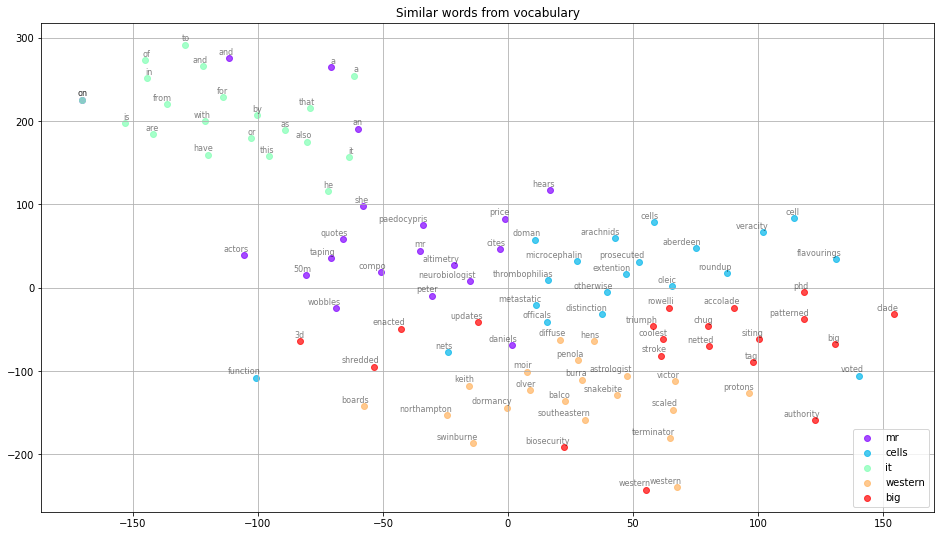

Epoch 2/5
1648388/1648388 [==============================] - 269s 163us/step - loss: 0.5658
Visualising similar words for epoch 1
Similar words to  mr  : 
mr altimetry neurobiologist peter daniels wobbles cites fats clips actors recourse 50m quotes she price portfolios december birdsong hears his 
Similar words to  cells  : 
cells aberdeen arachnids metastatic cell prosecuted veracity 03549 lrig1 doman prostate flavourings maher otherwise thrombophilias idiots distinction mussels nets function 
Similar words to  it  : 
it odder also no galina are new people that contemplates seminal raincoat coordinator on thangoo for wriggling he changes all 
Similar words to  western  : 
western diffuse burra hens woomera boards protons northampton victor forgers corrs giles moir olver keith balco champion penola toasty impairments 
Similar words to  big  : 
big shredded coolest theoreticians waugh irregularities western boucher songwriter phd 3d patterned authority whipping 95 rowelli biosecurity si

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

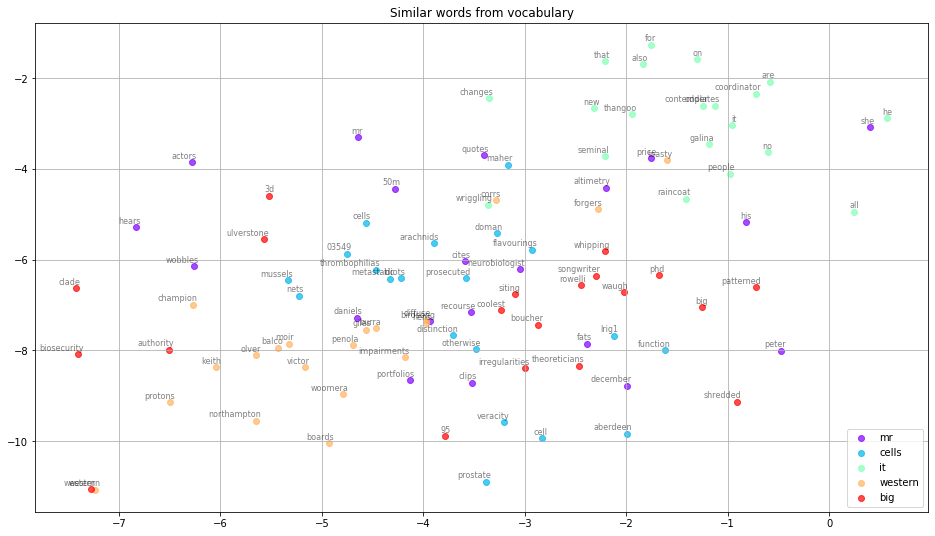

Epoch 3/5
1648388/1648388 [==============================] - 269s 163us/step - loss: 0.4632
Visualising similar words for epoch 2
Similar words to  mr  : 
mr altimetry neurobiologist peter daniels recourse fats wobbles birdsong cites portfolios clips actors price his 50m discarded synergy spokesman nineteen 
Similar words to  cells  : 
cells metastatic aberdeen arachnids prosecuted lrig1 cell 03549 prostate flavourings maher veracity doman manure them environmment mussels tua eggs stomachs 
Similar words to  it  : 
it odder no galina people raincoat also new wriggling auditings seminal admired thangoo defamation rapa fedsat price contemplates seung quita 
Similar words to  western  : 
western diffuse hens corrs toasty woomera burra preston boards forgers victor impairments protons northampton wakefield giles champion big palaeobiology moir 
Similar words to  big  : 
big coolest shredded theoreticians waugh irregularities western boucher whipping 3d 95 ulverstone phd authority patterned

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

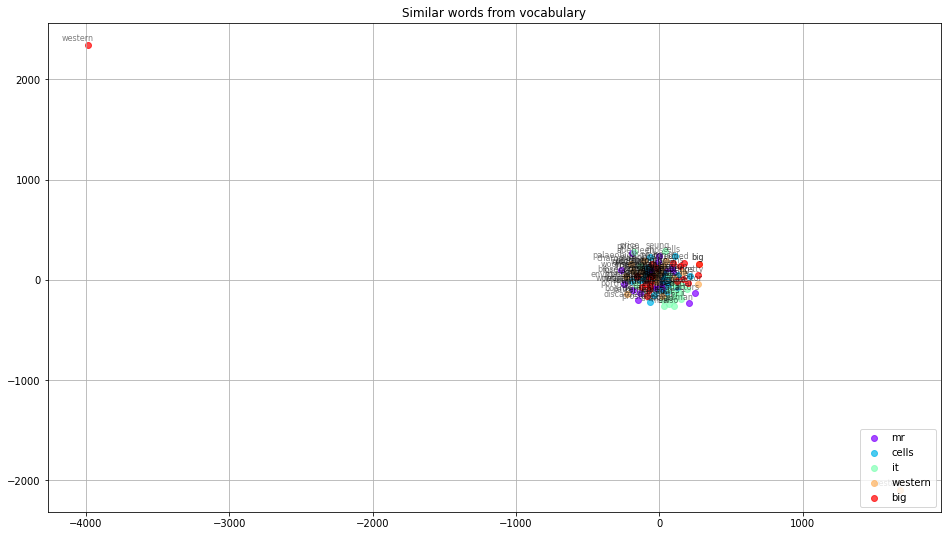

Epoch 4/5
1648388/1648388 [==============================] - 270s 164us/step - loss: 0.3725
Visualising similar words for epoch 3
Similar words to  mr  : 
mr altimetry neurobiologist daniels peter recourse fats portfolios birdsong clips cites wobbles actors spokesman synergy price discarded decimates 50m his 
Similar words to  cells  : 
cells metastatic aberdeen arachnids prosecuted lrig1 03549 cell flavourings prostate maher doman manure veracity stomachs environmment ovaries eggs idiots mussels 
Similar words to  it  : 
it odder no galina raincoat people wriggling auditings new also admired seminal seung rapa brownhill thangoo knotted fedsat defamation surfer 
Similar words to  western  : 
western diffuse hens corrs toasty preston woomera wakefield victor impairments boards protons champion palaeobiology northampton big burra forgers giles booming 
Similar words to  big  : 
big coolest shredded theoreticians waugh western irregularities boucher whipping ulverstone 3d 95 sainburys pat

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

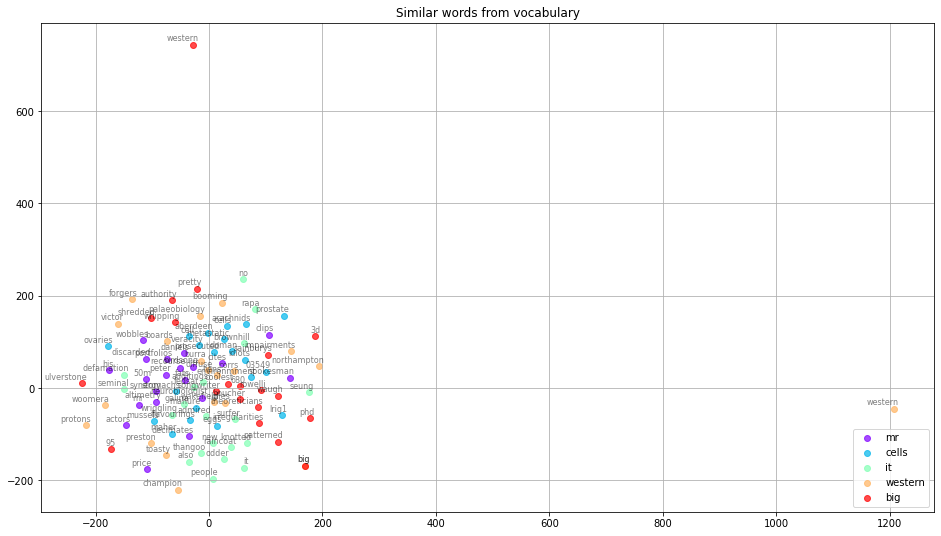

Epoch 5/5
1648388/1648388 [==============================] - 270s 164us/step - loss: 0.3046
Visualising similar words for epoch 4
Similar words to  mr  : 
mr altimetry neurobiologist daniels recourse portfolios fats peter birdsong clips actors cites wobbles synergy discarded spokesman decimates 50m 27cents perkasa 
Similar words to  cells  : 
cells metastatic aberdeen lrig1 prosecuted arachnids 03549 flavourings prostate cell ovaries doman maher manure pores module stomachs survivors idiots environmment 
Similar words to  it  : 
it raincoat people no galina odder auditings wriggling new politically seung knotted brownhill rapa admired fedsat seminal organophosphate surfer rained 
Similar words to  western  : 
western diffuse hens corrs toasty palaeobiology preston wakefield champion victor impairments quo boards protons big woomera northampton booming gold peers 
Similar words to  big  : 
big coolest shredded theoreticians waugh western irregularities whipping boucher ulverstone 95 sai

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

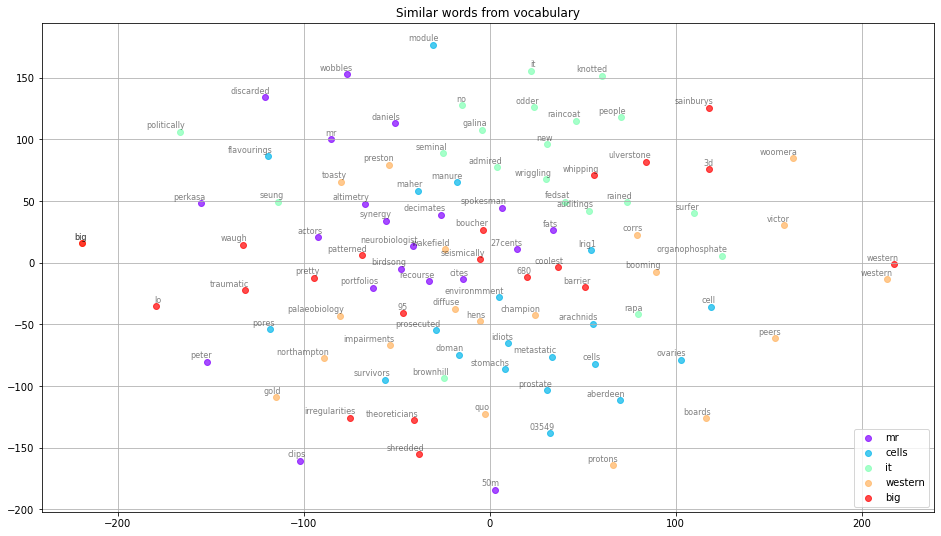

In [10]:
model.fit([word_target, word_context], labels, epochs=5, callbacks=[VisualiseEmbeddingsCallback()])